## Creat a connection to the database

In [2]:
import pandas as pd
import pymysql
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

host = 'sql314.your-server.de'
user = 'daq_db_user_r'
password = 'daq-DB-rd8820'
database = 'aquaculture_daq'

# Connect to the database
conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a cursor object
cursor = conn.cursor()


## Calculate the last five days

In [3]:
# Calculate the date 5 days ago
five_days_ago = (datetime.now() - timedelta(days=5)).strftime('%Y-%m-%d')
print(five_days_ago)

2025-02-23


## See whats in the tblLog
Fetch column names of tblLog

Fetch some sample data from tblLog

In [4]:
# Fetch column names of tblLog
cursor.execute('DESCRIBE tblLog')
columns_tblLog = cursor.fetchall()
print("Columns in tblLog:")
for column in columns_tblLog:
    print(column[0])

# Fetch some sample data from tblLog
cursor.execute('SELECT * FROM tblLog LIMIT 10')
sample_data = cursor.fetchall()
print("\nSample data from tblLog:")
for row in sample_data:
    print(row)
    

Columns in tblLog:
LogValueId
Timestamp
Value

Sample data from tblLog:
(34, 1693227380, 60.686000823975)
(85, 1693227380, 99.16748046875)
(86, 1693227380, 21.801830291748)
(87, 1693227380, 6.1084542274475)
(73, 1693227380, -28576.0)
(74, 1693227380, 8.0)
(76, 1693227380, 99.461616516113)
(77, 1693227380, 21.555435180664)
(78, 1693227380, 7.275411605835)
(88, 1693227380, 0.0)


In [5]:
# Fetch column names of tblLogValueId
cursor.execute('DESCRIBE tblLogValueId')
columns_tblLogValueId = cursor.fetchall()
print("Columns in tblLogValueId:")
for column in columns_tblLogValueId:
    print(column[0])

# Fetch some sample data from tblLogValueId
cursor.execute('SELECT * FROM tblLogValueId LIMIT 17')
sample_data = cursor.fetchall()
print("\nSample data from tblLogValueId:")
for row in sample_data:
    print(row)
    

Columns in tblLogValueId:
LogValueId
SystemId
ValueName
SensorId

Sample data from tblLogValueId:
(1, 6, 'Abwasserpumpe Leistung', 242)
(2, 6, 'Bio in CO2', 238)
(3, 6, 'Bio in NH4-N', 232)
(4, 6, 'Bio out CO2', 238)
(5, 6, 'Bio out NH4-N', 228)
(6, 6, 'Biofilter Abluft rH', 239)
(7, 6, 'Biofilter Abluft TEMP', 237)
(8, 6, 'Biofilter Zuluft rH', 239)
(9, 6, 'Biofilter Zuluft TEMP', 237)
(10, 6, 'Coldep CO2 Entgasung', 236)
(11, 6, 'Coldep Ozoneintrag', 236)
(12, 6, 'EC', 217)
(13, 6, 'Ozon Fischzucht', 241)
(14, 6, 'Ozon Zentrale', 241)
(15, 6, 'Raumluft rH', 239)
(16, 6, 'Raumluft TEMP', 237)
(17, 6, 'Redox', 235)


In [6]:
# Query to find LogValueId for Raumluft rH and Raumluft Temp
cursor.execute("SELECT LogValueId, ValueName FROM tblLogValueId WHERE ValueName LIKE '%Raumluft%'")
raumluft_data = cursor.fetchall()

# Print the results
print("LogValueId and ValueName for Raumluft measurements:")
for row in raumluft_data:
    print(row)

LogValueId and ValueName for Raumluft measurements:
(15, 'Raumluft rH')
(16, 'Raumluft TEMP')


In [7]:
# Calculate the timestamp for 5 days ago in Unix epoch format
five_days_ago = int((datetime.now() - timedelta(days=5)).timestamp())

# Fetch data for Raumluft rH and Raumluft Temp
query = """
SELECT l.Timestamp, v.ValueName, l.Value
FROM tblLog l
JOIN tblLogValueId v ON l.LogValueId = v.LogValueId
WHERE l.Timestamp >= %s AND v.ValueName IN ('Raumluft rH', 'Raumluft Temp')
"""
cursor.execute(query, (five_days_ago,))
data = cursor.fetchall()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=['Timestamp', 'ValueName', 'Value'])
print(df.head())

    Timestamp      ValueName      Value
0  1740300907    Raumluft rH  80.857594
1  1740300907  Raumluft TEMP  14.798929
2  1740301507    Raumluft rH  80.976585
3  1740301507  Raumluft TEMP  14.610198
4  1740302107    Raumluft rH  81.907991


In [8]:
# Convert Unix timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Pivot the data to separate Raumluft rH and Raumluft Temp
df_pivot = df.pivot(index='Timestamp', columns='ValueName', values='Value')
print(df_pivot.head())

ValueName            Raumluft TEMP  Raumluft rH
Timestamp                                      
2025-02-23 08:55:07      14.798929    80.857594
2025-02-23 09:05:07      14.610198    80.976585
2025-02-23 09:15:07      14.671741    81.907991
2025-02-23 09:25:07      14.971248    80.816563
2025-02-23 09:35:07      14.831752    80.480108


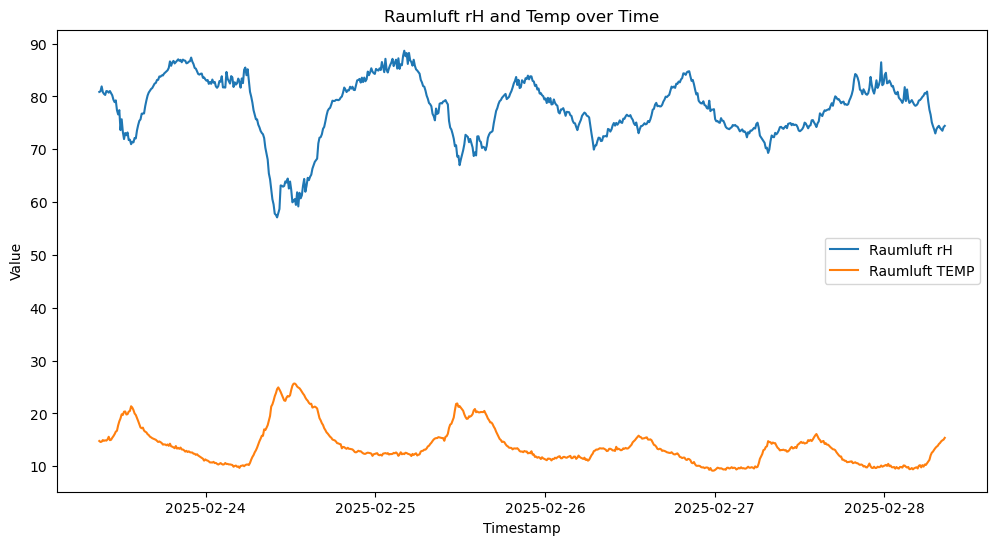

In [9]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df_pivot.index, df_pivot['Raumluft rH'], label='Raumluft rH')
plt.plot(df_pivot.index, df_pivot['Raumluft TEMP'], label='Raumluft TEMP')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Raumluft rH and Temp over Time')
plt.legend()
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression

# Prepare data for regression
X = df_pivot[['Raumluft TEMP']].dropna()  # Temperature as independent variable
y = df_pivot['Raumluft rH'].loc[X.index]  # Relative humidity as dependent variable

# Train the model
model = LinearRegression()
model.fit(X, y)

# Predict relative humidity at 20°C
predicted_rH = model.predict([[20]])
print(f"Predicted relative humidity at 20°C: {predicted_rH[0]:.2f}%")

Predicted relative humidity at 20°C: 70.62%


c:\Users\noiri\.conda\envs\eee\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
